In [ ]:
from pathlib import Path

import pandas as pd

from caveat.evaluate.describe import frequency, transitions
from caveat.evaluate.describe.frequency import frequency_plots
from caveat.evaluate.describe.times import times_distributions_plot
from caveat.evaluate.describe.transitions import sequence_prob_plot
from caveat.evaluate.describe.times import joint_time_distributions_plot

In [2]:
cmap = {
    "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    "other": (1.0, 1.0, 0.7019607843137254),
    "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    "education": (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
    "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
}


batch_paths = {
    # "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae_3"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    # "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}

# find data
target_schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
acts = list(target_schedules.act.value_counts(ascending=False).index)
class_map = {n: i for i, n in enumerate(acts)}


def latest(path: Path):
    versions = sorted(
        [
            d
            for d in path.iterdir()
            if d.is_dir() and d.name.startswith("version")
        ]
    )
    return path.name, versions[-1]


def iter_models(path: Path):
    for dir in path.iterdir():

        if dir.is_dir():

            yield latest(dir)


def find_best(path: Path):

    ranks = (
        pd.read_csv(path / "domain_distances.csv")
        .drop(columns=["domain", "observed", "mean", "std"], errors="ignore")
        .rank(axis=1, method="min")
        .sum(axis=0)
    )
    ranked = [i for _, i in sorted(zip(ranks, ranks.index))]
    top = ranked[0]
    dir = path / top
    yield latest(dir)


next(find_best(Path("../logs/paper_d_rnn")))

('DiscLSTM2', PosixPath('../logs/paper_d_rnn/DiscLSTM2/version_1'))

In [3]:
schedules = {
    n: pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")
    for n, p in batch_paths.items()
}
schedules = {k.removesuffix(" VAE"): v for k, v in schedules.items()}

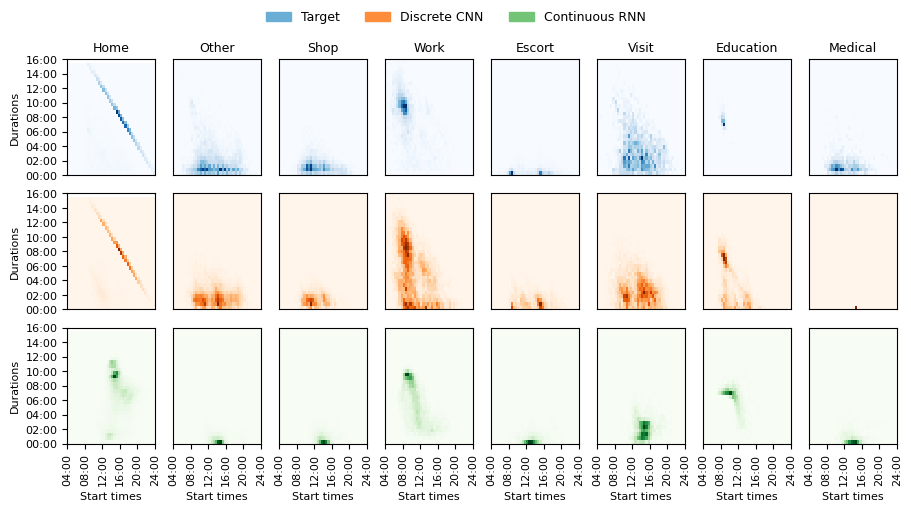

In [4]:
fig = joint_time_distributions_plot(
    target_schedules,
    schedules,
    figsize=(9, 5),
    observed_title="Target",
    cmaps={0: "Blues", 1: "Oranges", 2: "Greens"},
)

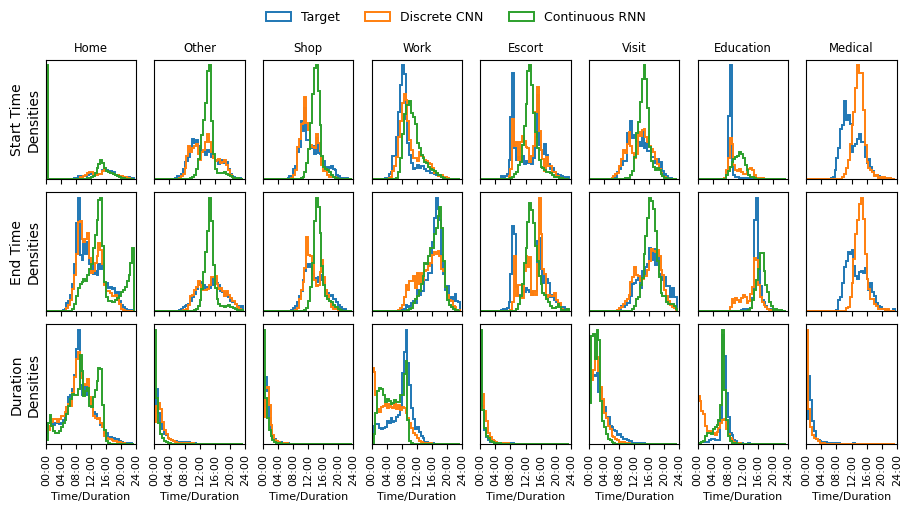

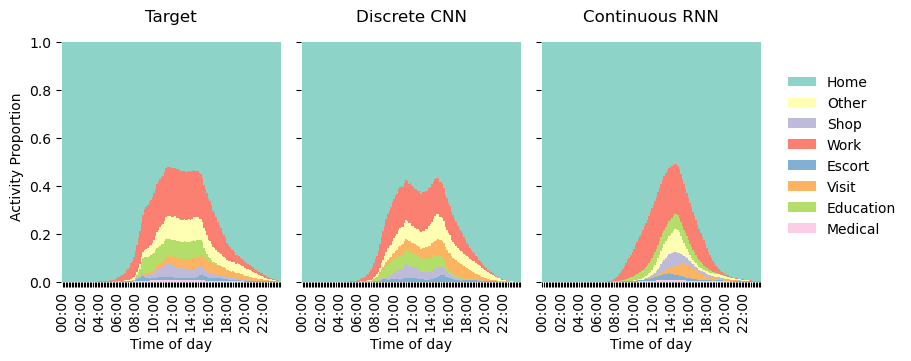

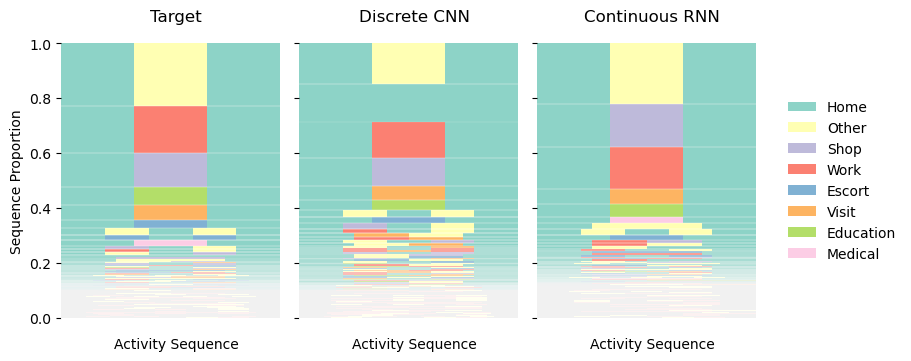

In [5]:
fig = times_distributions_plot(
    target_schedules, schedules, observed_title="Target", figsize=(9, 5)
)
fig = frequency_plots(
    target_schedules,
    schedules,
    color=cmap,
    figsize=(9, 3.5),
    observed_title="Target",
)
fig = sequence_prob_plot(
    target_schedules,
    schedules,
    cmap=cmap,
    figsize=(9, 3.5),
    observed_title="Target",
)

In [6]:
import random

from pam.core import Household, Person
from pam.plot.plans import plot_household

from caveat.data.utils import trace_to_pam


def stretch(schedules):
    return schedules.groupby(schedules.pid).apply(stretcher)


def stretcher(schedule):
    duration = schedule.duration.sum()
    if duration != 1440:
        a = 1440 / duration
        schedule.duration = (schedule.duration * a).astype(int)
        accumulated = list(schedule.duration.cumsum())
        schedule.start = [0] + accumulated[:-1]
        schedule.end = accumulated
    return schedule


def trim(schedules):
    schedules[schedules.end > 1440] = 1440
    schedules[schedules.start > 1440] = 1440
    schedules.duration = schedules.end - schedules.start
    schedules = schedules[schedules.duration > 0]
    return schedules


def pad(schedules):
    return (
        schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
    )


def padder(schedule):
    if schedule.end.iloc[-1] < 1440 and schedule.act.iloc[-1] != "home":
        pid = schedule.pid.iloc[0]
        schedule = pd.concat(
            [
                schedule,
                DataFrame(
                    {
                        "pid": pid,
                        "start": schedule.end.iloc[-1],
                        "end": 1440,
                        "duration": 1440 - schedule.end.iloc[-1],
                        "act": "home",
                    },
                    index=[0],
                ),
            ]
        )
    elif schedule.end.iloc[-1] < 1440:
        schedule.end.iloc[-1] = 1440
        schedule.duration.iloc[-1] = 1440 - schedule.start.iloc[-1]
    return schedule


def plot_schedules(schedules, **kwargs):

    cmap = {
        "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
        "other": (1.0, 1.0, 0.7019607843137254),
        "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
        "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
        "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
        "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
        "education": (
            0.7019607843137254,
            0.8705882352941177,
            0.4117647058823529,
        ),
        "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
        "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    }
    cmap = {n.title(): c for n, c in cmap.items()}

    hh = Household("")

    pids = schedules.pid
    selected = random.sample(list(pids), 5)
    for i, pid in enumerate(selected):
        person = Person(pid)
        plan = schedules[schedules.pid == pid]
        plan = trim(stretch(pad(plan)))[["act", "start", "end", "duration"]]
        mapping = {a: a for a in plan.act}

        trace = [
            (row.act, row.start, row.end, row.duration)
            for i, row in plan.iterrows()
        ]
        plan = trace_to_pam(trace, mapping)

        person = Person(i)
        person.plan = plan
        hh.add(person)

    plot_household(hh, cmap=cmap, width=25)

/tmp/ipykernel_381637/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_381637/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_381637/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

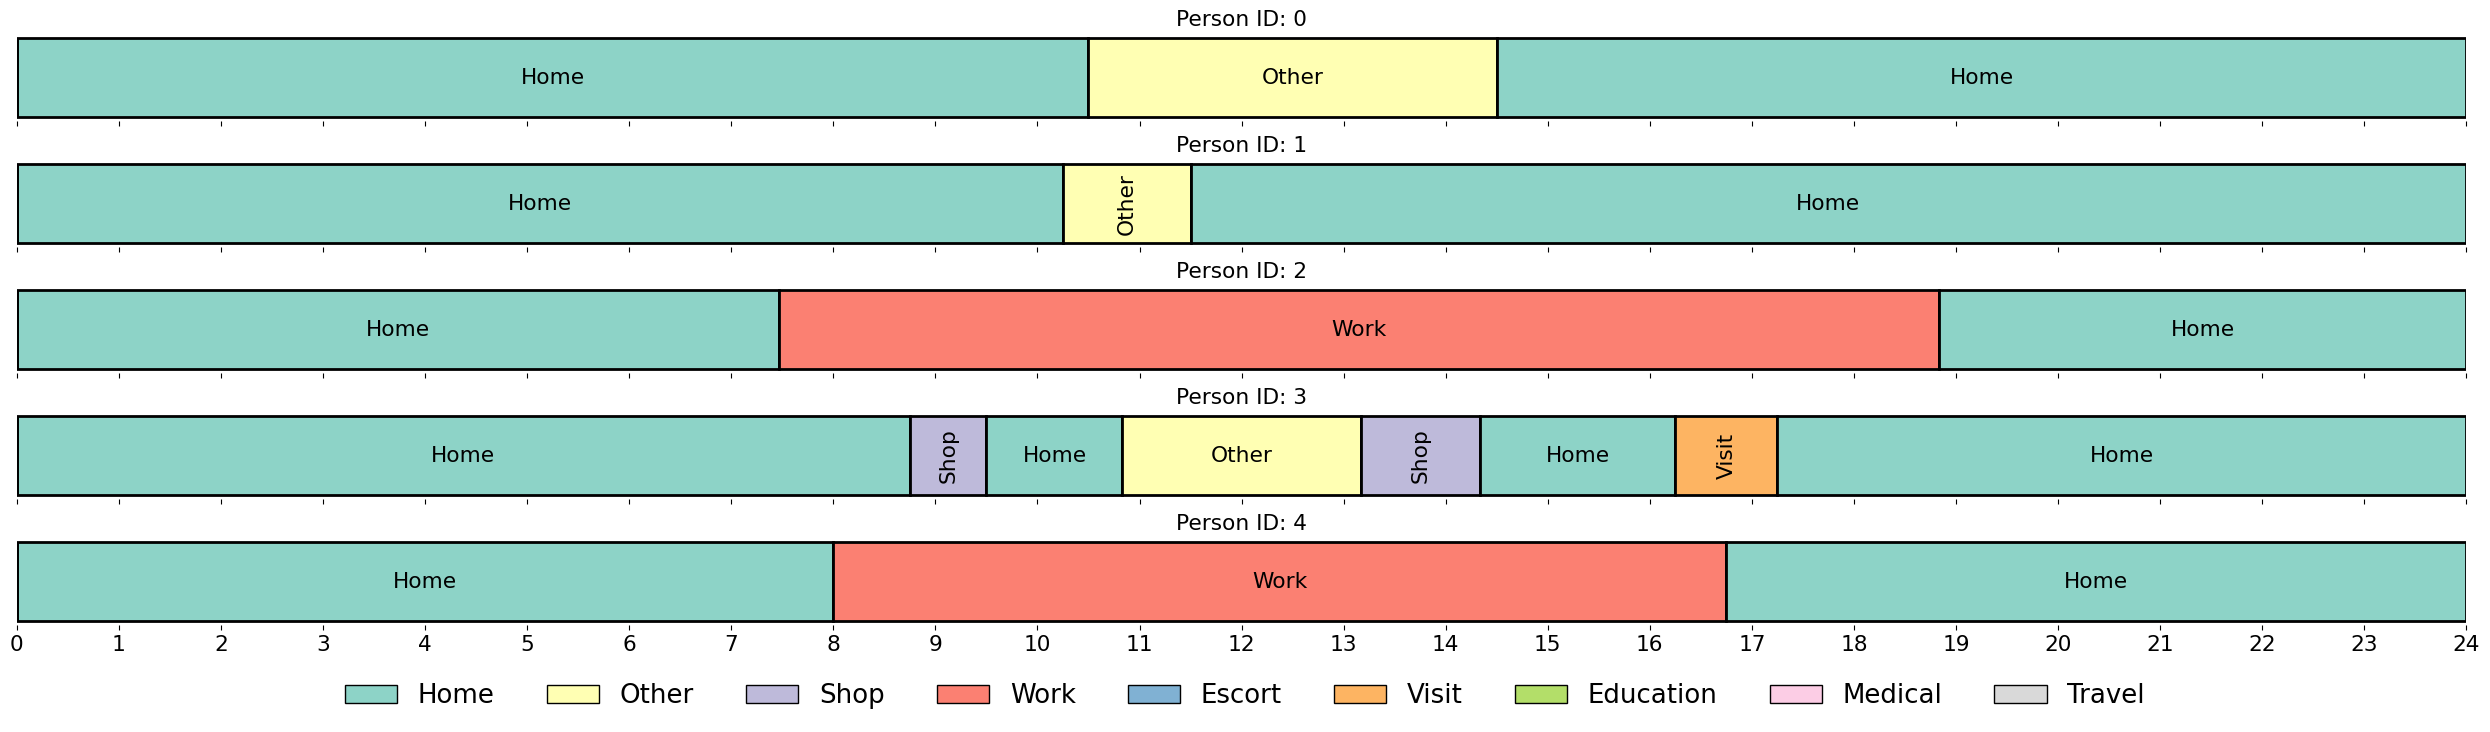

In [31]:
plot_schedules(target_schedules)

/tmp/ipykernel_381637/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_381637/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_381637/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

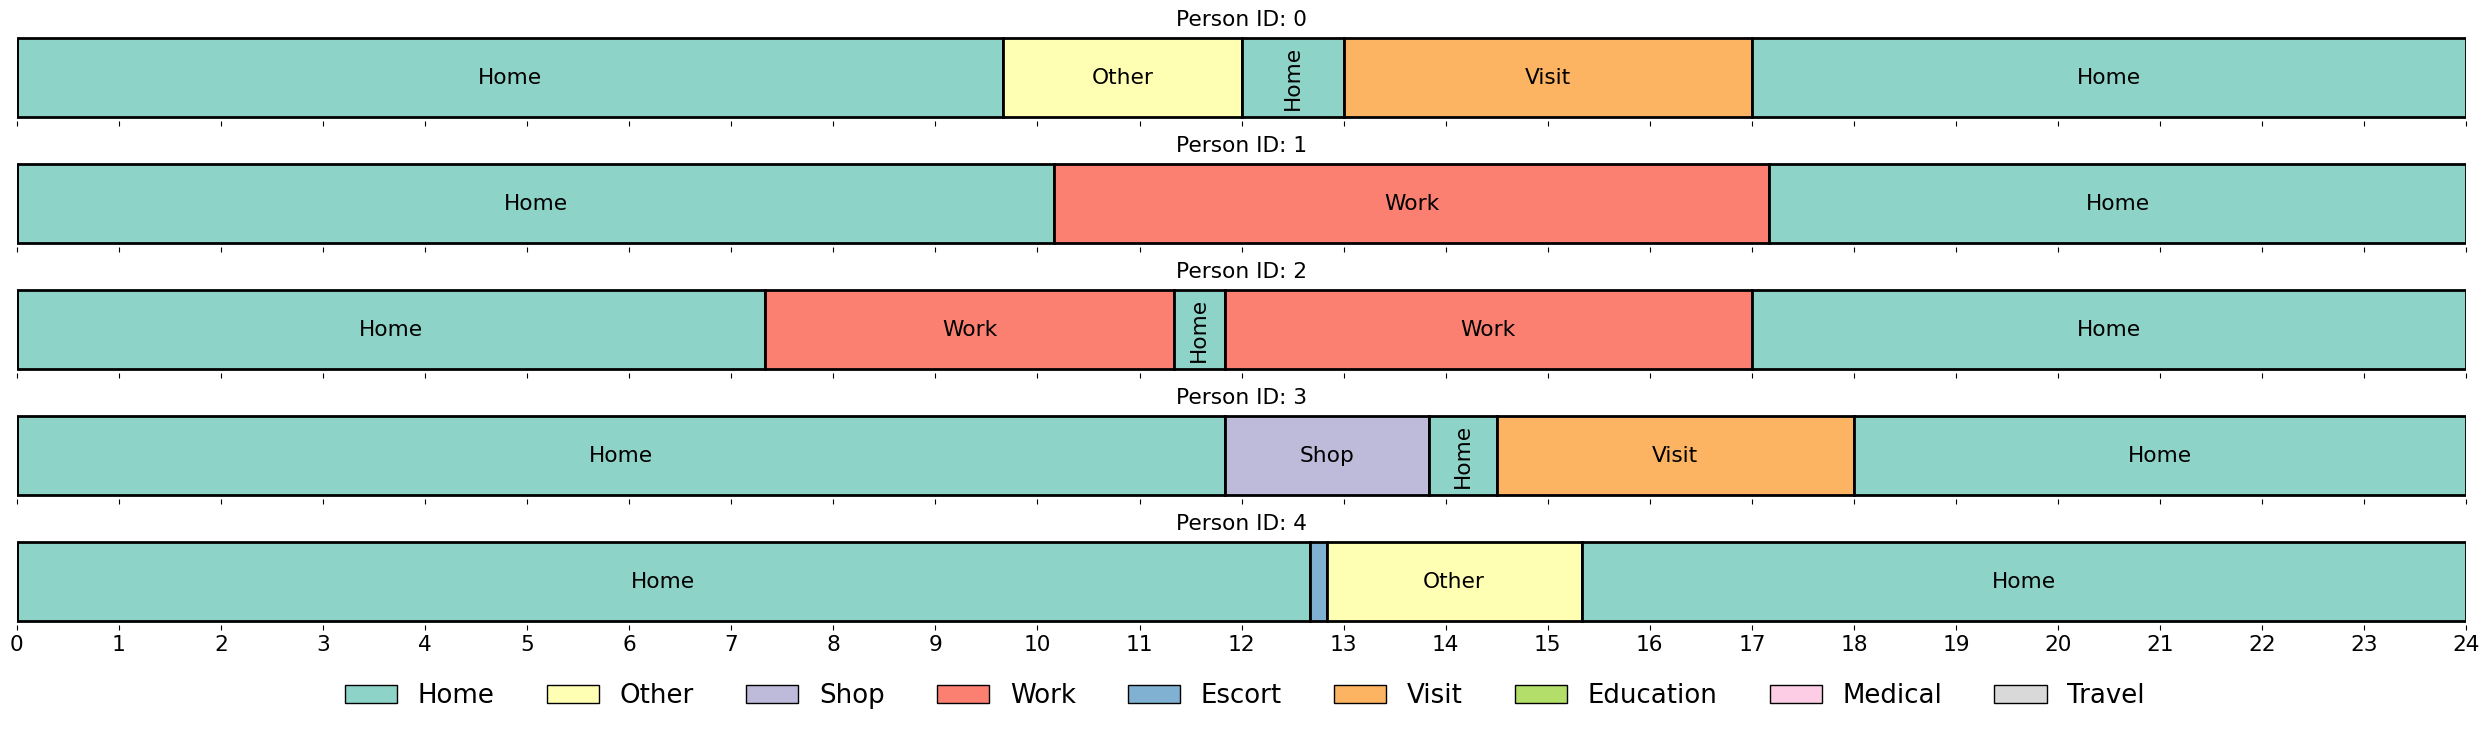

In [29]:
p = batch_paths["Discrete CNN VAE"]
schedules = pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")

plot_schedules(schedules)

/tmp/ipykernel_381637/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_381637/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_381637/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

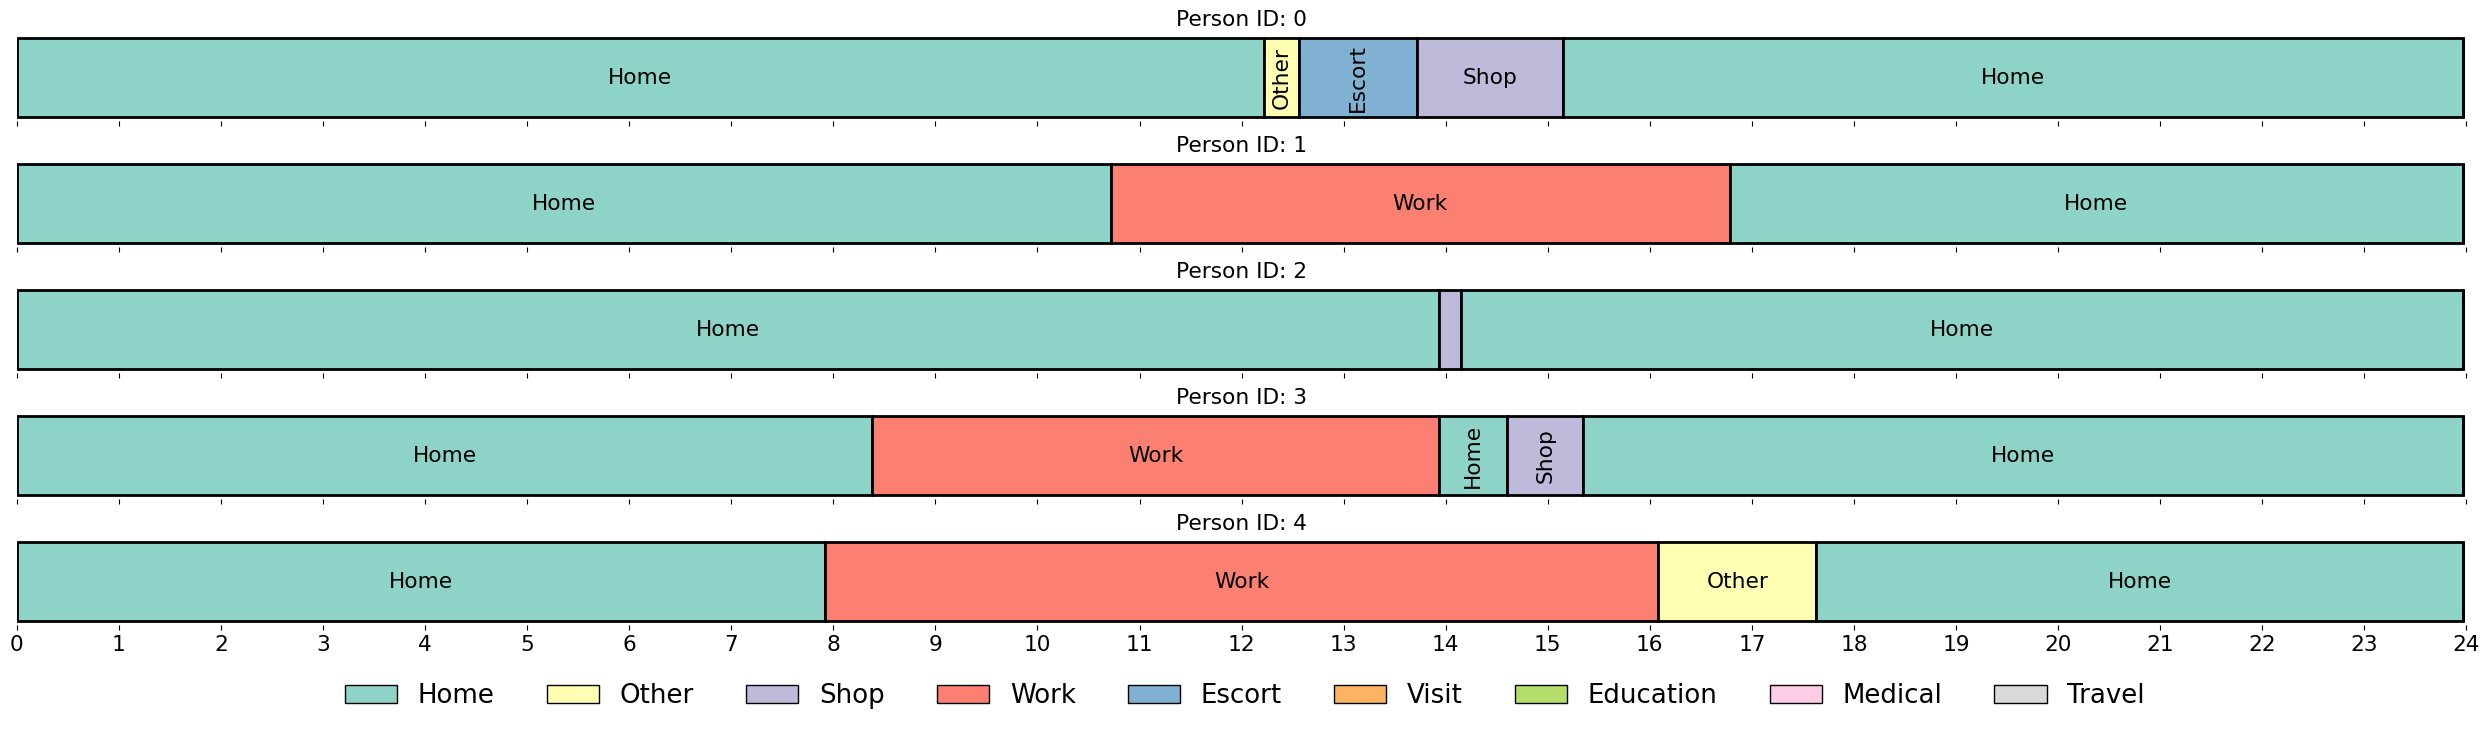

In [35]:
p = batch_paths["Continuous RNN VAE"]
schedules = pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")

plot_schedules(schedules)

In [10]:
def build_distance_tables(batch_paths, suffix=""):
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():
        distances = pd.read_csv(
            path / f"domain_distances{suffix}.csv"
        ).set_index("domain")

        columns = list(
            set(distances.columns) - set(["domain", "observed", "mean", "std"])
        )
        distances_combined[(name, "EMD")] = distances[columns].mean(axis=1)
        distances_combined[(name, "var")] = distances[columns].var(axis=1)

    distances_combined.columns = pd.MultiIndex.from_tuples(
        distances_combined.columns
    )

    # distances_combined = distances_combined.set_index(
    #     pd.MultiIndex.from_tuples(distances_combined.index)
    # )

    return distances_combined


df = build_distance_tables(batch_paths)
df

Discrete CNN VAE               Continuous RNN VAE              
                            EMD           var                EMD           var
domain                                                                        
aggregate              0.005691  6.075646e-07           0.017256  2.349330e-06
count                  0.000000  0.000000e+00           0.000000  0.000000e+00
creativity             0.280591  8.444305e-06           0.225165  2.731747e-10
participations         0.135863  5.701677e-05           0.067215  3.262064e-04
sample quality         0.000001  8.981578e-12           0.053341  6.617773e-05
timing                 0.044200  4.633290e-06           0.067600  2.696004e-06
transitions            0.011156  4.537886e-07           0.006613  1.043057e-06

In [11]:
print(df[::-1].to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
 & EMD & var & EMD & var \\
domain &  &  &  &  \\
\midrule
aggregate & 0.006 & 0.000 & 0.017 & 0.000 \\
count & 0.000 & 0.000 & 0.000 & 0.000 \\
creativity & 0.281 & 0.000 & 0.225 & 0.000 \\
participations & 0.136 & 0.000 & 0.067 & 0.000 \\
sample quality & 0.000 & 0.000 & 0.053 & 0.000 \\
timing & 0.044 & 0.000 & 0.068 & 0.000 \\
transitions & 0.011 & 0.000 & 0.007 & 0.000 \\
\bottomrule
\end{tabular}



In [ ]:
def build_description_tables(batch_paths, suffix=""):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(
            path / f"feature_descriptions{suffix}.csv"
        ).set_index(["domain", "feature"])
        columns = set(descriptions.columns)
        columns = list(columns - set(["observed", "description"]))
        assert len(columns) == 5

        descriptions_combined[(name, "mean")] = descriptions[columns].mean(
            axis=1
        )
        descriptions_combined[(name, "var")] = descriptions[columns].var(axis=1)

    descriptions_combined[("Observed", "")] = descriptions["observed"]

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    return (creativity, sample_quality, density)


creativity, sample_quality, density = build_description_tables(batch_paths)

In [13]:
print(creativity.loc[::-1, :].to_latex(float_format="{:.3f}".format))
creativity.loc[::-1, :]

\begin{tabular}{lrrrr}
\toprule
feature & \multicolumn{2}{r}{diversity} & \multicolumn{2}{r}{novelty} \\
 & mean & std & mean & std \\
\midrule
Observed & 0.550 & 0.000 & 1.000 & 0.000 \\
Discrete CNN VAE & 0.524 & 0.020 & 0.889 & 0.006 \\
Continuous RNN VAE & 0.995 & 0.002 & 1.000 & 0.000 \\
\bottomrule
\end{tabular}



feature            diversity             novelty          
                        mean       std      mean       std
Observed            0.549724  0.000000  1.000000  0.000000
Discrete CNN VAE    0.524318  0.020152  0.889095  0.005812
Continuous RNN VAE  0.994660  0.002416  0.999946  0.000033

In [14]:
print(sample_quality.loc[::-1, :].to_latex(float_format="{:.3f}".format))
sample_quality.loc[::-1, :]

\begin{tabular}{lrrrr}
\toprule
feature & \multicolumn{2}{r}{duration} & \multicolumn{2}{r}{home based} \\
 & mean & std & mean & std \\
\midrule
Observed & 1.000 & 0.000 & 1.000 & 0.000 \\
Discrete CNN VAE & 1.000 & 0.000 & 1.000 & 0.000 \\
Continuous RNN VAE & 0.974 & 0.012 & 0.981 & 0.004 \\
\bottomrule
\end{tabular}



feature             duration          home based          
                        mean      std       mean       std
Observed            1.000000  0.00000   1.000000  0.000000
Discrete CNN VAE    1.000000  0.00000   0.999997  0.000006
Continuous RNN VAE  0.973597  0.01193   0.981121  0.004111

In [15]:
def build_feature_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "feature_descriptions.csv").set_index(
            ["domain", "feature"]
        )
        distances = pd.read_csv(path / "feature_distances.csv").set_index(
            ["domain", "feature"]
        )
        print(distances.columns)

        columns = set(descriptions.columns)
        columns = list(
            columns - set(["observed", "description", "mean", "std"])
        )
        assert len(columns) == 5

        descriptions_combined[(name, "mean")] = descriptions[columns].mean(
            axis=1
        )
        # descriptions_combined[(name, "var")] = descriptions[columns].var(axis=1)
        descriptions_combined[(name, "EMD")] = distances[columns].mean(axis=1)

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    descriptions_combined[("Observed", "")] = descriptions["observed"]
    descriptions_combined[("Description", "")] = descriptions["description"]

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order = [("Observed", "")] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_feature_description_tables(batch_paths)
table

Index(['observed', 'paper_d_cnn_vae_3_nrun0', 'paper_d_cnn_vae_3_nrun1',
       'paper_d_cnn_vae_3_nrun2', 'paper_d_cnn_vae_3_nrun3',
       'paper_d_cnn_vae_3_nrun4', 'distance'],
      dtype='object')
Index(['observed', 'paper_c_rnn_vae_nrun0', 'paper_c_rnn_vae_nrun1',
       'paper_c_rnn_vae_nrun2', 'paper_c_rnn_vae_nrun3',
       'paper_c_rnn_vae_nrun4', 'distance'],
      dtype='object')


Observed Discrete CNN VAE            \
                                                             mean       EMD   
domain         feature                                                        
creativity     diversity                0.549724         0.524318       NaN   
               novelty                  1.000000         0.889095       NaN   
sample quality duration                 1.000000         1.000000  0.000000   
               home based               1.000000         0.999997  0.000003   
aggregate      agg. frequency           0.688881         0.720028  0.005691   
participations lengths                  3.680427         3.404954  0.379628   
               pair participation rate  0.038617         0.036632  0.012319   
               participation rate       0.085591         0.083119  0.015642   
transitions    2-gram                   0.041891         0.067498  0.018534   
               3-gram                   0.005097         0.011110  0.003777   
timing         durations                0.271708         0.293815  0.040725   
               end times                0.683808         0.693799  0.044945   
               start times              0.412100         0.399984  0.019852   
               start-durations          0.689380         0.698369  0.071279   

                                       Continuous RNN VAE            \
                                                     mean       EMD   
domain         feature                                                
creativity     diversity                         0.994660       NaN   
               novelty                           0.999946       NaN   
sample quality duration                          0.973597  0.087803   
               home based                        0.981121  0.018879   
aggregate      agg. frequency                    0.760902  0.017256   
participations lengths                           3.524109  0.186844   
               pair participation rate           0.038162  0.005680   
               participation rate                0.080965  0.009119   
transitions    2-gram                            0.042009  0.010643   
               3-gram                            0.004936  0.002583   
timing         durations                         0.276320  0.050464   
               end times                         0.706178  0.070662   
               start times                       0.429858  0.045810   
               start-durations                   0.708213  0.103464   

                                          Description  
                                                       
domain         feature                                 
creativity     diversity                 prob. unique  
               novelty                    prob. novel  
sample quality duration                      duration  
               home based                       prob.  
aggregate      agg. frequency           average freq.  
participations lengths                        length.  
               pair participation rate       av rate.  
               participation rate            av. rate  
transitions    2-gram                        av. rate  
               3-gram                        av. rate  
timing         durations                      average  
               end times                      average  
               start times                    average  
               start-durations                average

In [16]:
for n in ["aggregate", "participations", "transitions", "timing"]:
    print(n)
    print(table.loc[n].to_latex(float_format="{:.3f}".format))
    print()

aggregate
\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
feature &  &  &  &  &  &  \\
\midrule
agg. frequency & 0.689 & 0.720 & 0.006 & 0.761 & 0.017 & average freq. \\
\bottomrule
\end{tabular}


participations
\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
feature &  &  &  &  &  &  \\
\midrule
lengths & 3.680 & 3.405 & 0.380 & 3.524 & 0.187 & length. \\
pair participation rate & 0.039 & 0.037 & 0.012 & 0.038 & 0.006 & av rate. \\
participation rate & 0.086 & 0.083 & 0.016 & 0.081 & 0.009 & av. rate \\
\bottomrule
\end{tabular}


transitions
\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
feature 

In [ ]:
def build_creativity_table(batch_paths):
    descriptions_combined = pd.DataFrame()
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = (
            pd.read_csv(path / "descriptions.csv")
            .set_index(["domain", "feature", "segment"])
            .loc["creativity"]
        )
        distances = (
            pd.read_csv(path / "distances.csv")
            .set_index(["domain", "feature", "segment"])
            .loc["creativity"]
        )

        columns = set(descriptions.columns)
        weights = set([c for c in columns if "weight" in c])
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
            - weights
        )

        descriptions_combined[name, "desc."] = descriptions[columns].mean(
            axis=1
        )

        distances_combined[name, "dist."] = distances[columns].mean(axis=1)

    descriptions_combined["Observed", ""] = descriptions["observed"]
    descriptions_combined["Description", ""] = descriptions["description"]

    print(descriptions_combined.columns)

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    distances_combined["Observed", ""] = distances["observed"]
    distances_combined["Description", ""] = distances["distance"]

    distances_combined.columns = pd.MultiIndex.from_tuples(
        distances_combined.columns
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order.pop(order.index(("Description", "")))
    order = [("Observed", "")] + order + [("Description", "")]
    descriptions_combined = descriptions_combined.loc[:, order]

    order = list(distances_combined.columns)
    order.pop(order.index(("Observed", "")))
    order.pop(order.index(("Description", "")))
    order = [("Observed", "")] + order + [("Description", "")]
    distances_combined = distances_combined.loc[:, order]

    return pd.concat((descriptions_combined, distances_combined), axis=0)


table = build_creativity_table(batch_paths)
table

Index([  ('Discrete CNN VAE', 'desc.'), ('Continuous RNN VAE', 'desc.'),
                      ('Observed', ''),             ('Description', '')],
      dtype='object')


,,Observed,Discrete CNN VAE,Continuous RNN VAE,Description,Discrete CNN VAE,Continuous RNN VAE
,,,desc.,desc.,,dist.,dist.
feature,segment,,,,,,
diversity,all,0.549724,0.524318,0.994660,prob. unique,NaN,NaN
novelty,all,1.000000,0.889095,0.999946,prob. novel,NaN,NaN
homogeneity,all,0.450276,NaN,NaN,prob. not unique,0.450276,0.450276
conservatism,all,0.000000,NaN,NaN,prob. conservative,0.110905,0.000054


In [ ]:
(25 * (1 - 0.974)) * 60

39.000000000000036

In [ ]:
def build_all_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions.csv").set_index(
            ["domain", "feature", "segment"]
        )
        distances = pd.read_csv(path / "distances.csv").set_index(
            ["domain", "feature", "segment"]
        )

        columns = set(descriptions.columns)
        weights = set([c for c in columns if "weight" in c])
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
            - weights
        )

        descriptions_combined[name, "mean"] = descriptions[columns].mean(axis=1)
        # descriptions_combined[name, "var"] = descriptions[columns].var(axis=1)
        descriptions_combined[name, "EMD"] = distances[columns].mean(axis=1)

    descriptions_combined["weight", ""] = distances["observed__weight"]
    descriptions_combined["Observed", ""] = descriptions["observed"]
    descriptions_combined["Description", ""] = descriptions["description"]

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    descriptions_combined = descriptions_combined.groupby(
        ["domain", "feature"], group_keys=False
    ).apply(
        lambda x: x.sort_values(
            [("weight", ""), ("Observed", "")], ascending=False
        ).head(20)
    )
    descriptions_combined = descriptions_combined.drop(("weight", ""), axis=1)

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order = [("Observed", "")] + order

    index = [
        "aggregate",
        "participations",
        "transitions",
        "timing",
        "sample quality",
        "creativity",
    ]

    return descriptions_combined.loc[index, order]


table = build_all_description_tables(batch_paths)

                   (Discrete CNN VAE, mean)  (Discrete CNN VAE, EMD)  \
feature   segment                                                      
diversity all                      0.524318                      NaN   
novelty   all                      0.889095                      NaN   

                   (Continuous RNN VAE, mean)  (Continuous RNN VAE, EMD)  \
feature   segment                                                          
diversity all                        0.994660                        NaN   
novelty   all                        0.999946                        NaN   

                   (weight, )  (Observed, ) (Description, )  
feature   segment                                            
diversity all             NaN      0.549724    prob. unique  
novelty   all             NaN      1.000000     prob. novel  


In [38]:
print(table.loc["sample quality"].to_latex(float_format="{:.3f}".format))
table.loc["sample quality"]

\begin{tabular}{llrrrrrl}
\toprule
 &  & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  &  & mean & EMD & mean & EMD &  \\
feature & segment &  &  &  &  &  &  \\
\midrule
duration & total duration & 1.000 & 1.000 & 0.000 & 0.974 & 0.088 & duration \\
\cline{1-8}
\multirow[t]{2}{*}{home based} & first act home & 1.000 & 1.000 & 0.000 & 1.000 & 0.000 & prob. \\
 & last act home & 1.000 & 1.000 & 0.000 & 0.962 & 0.038 & prob. \\
\cline{1-8}
\bottomrule
\end{tabular}



Observed Discrete CNN VAE            \
                                               mean       EMD   
feature    segment                                              
duration   total duration      1.0         1.000000  0.000000   
home based first act home      1.0         1.000000  0.000000   
           last act home       1.0         0.999995  0.000005   

                          Continuous RNN VAE           Description  
                                        mean       EMD              
feature    segment                                                  
duration   total duration           0.973597  0.087803    duration  
home based first act home           1.000000  0.000000       prob.  
           last act home            0.962242  0.037758       prob.

In [39]:
table.loc["creativity"]

Observed Discrete CNN VAE     Continuous RNN VAE      \
                                        mean EMD               mean EMD   
feature   segment                                                         
diversity all      0.549724         0.524318 NaN           0.994660 NaN   
novelty   all      1.000000         0.889095 NaN           0.999946 NaN   

                    Description  
                                 
feature   segment                
diversity all      prob. unique  
novelty   all       prob. novel

In [19]:
p = table.loc["participations"]
for name in ["lengths", "participation rate", "pair participation rate"]:
    print(name)
    print(p.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["participations"]

lengths
\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  \\
\midrule
sequence lengths & 3.680 & 3.405 & 0.380 & 3.524 & 0.187 & length. \\
\bottomrule
\end{tabular}


participation rate
\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  \\
\midrule
home0 & 1.000 & 1.000 & 0.000 & 1.000 & 0.000 & av. rate \\
home1 & 1.000 & 0.852 & 0.148 & 0.968 & 0.032 & av. rate \\
other0 & 0.394 & 0.373 & 0.023 & 0.375 & 0.027 & av. rate \\
work0 & 0.237 & 0.247 & 0.028 & 0.247 & 0.019 & av. rate \\
shop0 & 0.233 & 0.199 & 0.034 & 0.250 & 0.021 & av. rate \\
home2 & 0.206 & 0.190 & 0.032 & 0.084 & 0.122 & av. rate \\
escort0 & 0.140 & 0.060 & 0.080 & 0.126 & 0.014 & av. rate \\
visit0 & 0.109 & 0

Observed Discrete CNN VAE            \
                                                               mean       EMD   
feature                 segment                                                 
lengths                 sequence lengths  3.680427         3.404954  0.379628   
pair participation rate home+home         1.039565         0.866660  0.172969   
                        escort+escort     0.069613         0.014041  0.055594   
                        home+escort       0.067201         0.013976  0.053418   
                        other+other       0.056318         0.055900  0.009993   
                        home+other        0.055246         0.055653  0.009167   
                        shop+shop         0.023401         0.014748  0.008653   
                        home+shop         0.023160         0.014689  0.008535   
                        work+work         0.013027         0.029432  0.017230   
                        home+work         0.011982         0.028462  0.016737   
                        visit+visit       0.009864         0.020313  0.010449   
                        home+visit        0.009784         0.019943  0.010170   
                        escort+other      0.002493         0.000000  0.002493   
                        shop+escort       0.001447         0.000247  0.001201   
                        shop+other        0.001153         0.000482  0.000917   
                        home+medical      0.001019         0.000075  0.000954   
                        medical+medical   0.001019         0.000075  0.000954   
                        work+escort       0.000911         0.000075  0.000836   
                        escort+visit      0.000697         0.000000  0.000697   
                        other+visit       0.000563         0.001699  0.001812   
                        shop+visit        0.000536         0.000279  0.000590   
participation rate      home0             1.000000         1.000000  0.000000   
                        home1             0.999786         0.851670  0.148116   
                        other0            0.393690         0.372857  0.022967   
                        work0             0.237174         0.246893  0.028001   
                        shop0             0.232510         0.198885  0.033625   
                        home2             0.205624         0.189841  0.031587   
                        escort0           0.139897         0.059765  0.080132   
                        visit0            0.109419         0.215713  0.106294   
                        education0        0.074814         0.081322  0.007452   
                        escort1           0.064762         0.012931  0.051831   
                        other1            0.054361         0.055498  0.008438   
                        home3             0.038332         0.014523  0.023809   
                        medical0          0.037233         0.000397  0.036836   
                        shop1             0.022999         0.014609  0.008390   
                        work1             0.011768         0.028333  0.016566   
                        escort2           0.011419         0.003083  0.008336   
                        other2            0.010293         0.004155  0.006138   
                        visit1            0.009757         0.019916  0.010159   
                        home4             0.005763         0.002048  0.003715   
                        escort3           0.004316         0.000976  0.003340   

                                         Continuous RNN VAE            \
                                                       mean       EMD   
feature                 segment                                         
lengths                 sequence lengths           3.524109  0.186844   
pair participation rate home+home                  0.974154  0.065410   
                        escort+escort              0.054570  0.016030   
                        home+escort    

In [20]:
t = table.loc["transitions"]
for name in ["2-gram", "3-gram"]:
    print(name)
    print(t.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["transitions"]

2-gram
\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  \\
\midrule
other>home & 0.414 & 0.433 & 0.052 & 0.351 & 0.063 & av. rate \\
home>other & 0.414 & 0.422 & 0.039 & 0.353 & 0.061 & av. rate \\
home>work & 0.229 & 0.270 & 0.045 & 0.234 & 0.021 & av. rate \\
work>home & 0.225 & 0.248 & 0.035 & 0.212 & 0.021 & av. rate \\
shop>home & 0.224 & 0.227 & 0.014 & 0.211 & 0.020 & av. rate \\
home>shop & 0.213 & 0.215 & 0.011 & 0.200 & 0.020 & av. rate \\
home>escort & 0.178 & 0.076 & 0.104 & 0.118 & 0.059 & av. rate \\
escort>home & 0.169 & 0.073 & 0.098 & 0.098 & 0.071 & av. rate \\
visit>home & 0.103 & 0.175 & 0.073 & 0.089 & 0.023 & av. rate \\
home>visit & 0.094 & 0.166 & 0.072 & 0.077 & 0.027 & av. rate \\
home>education & 0.073 & 0.094 & 0.021 & 0.068 & 0.015 & av. rate \\
education>home & 0.070 & 0.086 & 0.018 & 0.055 & 0.015 & av

Observed Discrete CNN VAE            \
                                                  mean       EMD   
feature segment                                                    
2-gram  other>home           0.414365         0.433470  0.051751   
        home>other           0.414258         0.422027  0.038534   
        home>work            0.229288         0.269698  0.044559   
        work>home            0.224838         0.247579  0.035291   
        shop>home            0.224221         0.227143  0.013946   
        home>shop            0.213363         0.214681  0.010758   
        home>escort          0.177543         0.075888  0.103819   
        escort>home          0.168829         0.073051  0.097961   
        visit>home           0.102552         0.175341  0.073492   
        home>visit           0.093973         0.165782  0.072185   
        home>education       0.072738         0.094218  0.021480   
        education>home       0.070084         0.085742  0.017796   
        home>medical         0.034854         0.000567  0.034376   
        medical>home         0.031128         0.000529  0.030688   
        other>other          0.019170         0.000000  0.019170   
        escort>escort        0.019009         0.000000  0.019009   
        home>home            0.015443         0.000000  0.015443   
        shop>shop            0.014987         0.000000  0.014987   
        escort>work          0.010805         0.003113  0.007694   
        other>shop           0.010322         0.012069  0.008379   
3-gram  home>other>home      0.388414         0.366222  0.044299   
        home>work>home       0.214050         0.207995  0.019868   
        home>shop>home       0.192041         0.196170  0.014231   
        home>escort>home     0.136573         0.059730  0.079348   
        home>visit>home      0.081835         0.112096  0.031006   
        home>education>home  0.069383         0.071642  0.015619   
        other>home>other     0.038116         0.049658  0.016980   
        escort>home>escort   0.037466         0.015319  0.025031   
        home>medical>home    0.029074         0.000504  0.028660   
        shop>home>other      0.019870         0.025188  0.007005   
        other>home>shop      0.016351         0.010313  0.006038   
        work>home>other      0.014348         0.017985  0.004538   
        other>home>escort    0.013508         0.006398  0.007110   
        home>escort>escort   0.013508         0.000000  0.013508   
        escort>escort>home   0.012994         0.000000  0.012994   
        other>other>home     0.012994         0.000000  0.012994   
        home>other>other     0.012561         0.000000  0.012561   
        escort>home>other    0.012371         0.004598  0.007774   
        shop>shop>home       0.011911         0.000000  0.011911   
        home>shop>shop       0.011424         0.000000  0.011424   

                            Continuous RNN VAE           Description  
                                          mean       EMD              
feature segment                                                       
2-gram  other>home                    0.351187  0.063179    av. rate  
        home>other                    0.352914  0.061344    av. rate  
        home>work                     0.233894  0.021349    av. rate  
        work>home                     0.211992  0.021111    av. rate  
        shop>home                     0.210796  0.020427    av. rate  
        home>shop                     0.199505  0.019603    av. rate  
        home>escort                   0.118164  0.059379    av. rate  
        escort>home                   0.097956  0.070873    av. rate  
        visit>home                    0.088682  0.023489    av. rate  
        home>visit                    0.077374  0.027215    av. rate  
        home>education                0.067685  0.014786    av. rate  
        education>home                0.055369  0.014715    av. rate  
        home>medical                  0

In [21]:
t = table.loc["timing"]
for name in ["durations", "start times", "end times", "start-durations"]:
    print(name)
    print(t.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["timing"]

durations
\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  \\
\midrule
home0 & 0.458 & 0.537 & 0.079 & 0.530 & 0.089 & average \\
home1 & 0.307 & 0.303 & 0.011 & 0.298 & 0.032 & average \\
other0 & 0.079 & 0.082 & 0.016 & 0.029 & 0.051 & average \\
work0 & 0.339 & 0.245 & 0.094 & 0.298 & 0.044 & average \\
shop0 & 0.051 & 0.057 & 0.009 & 0.022 & 0.030 & average \\
home2 & 0.244 & 0.245 & 0.022 & 0.270 & 0.038 & average \\
escort0 & 0.030 & 0.039 & 0.014 & 0.023 & 0.007 & average \\
visit0 & 0.136 & 0.116 & 0.021 & 0.082 & 0.056 & average \\
education0 & 0.293 & 0.177 & 0.116 & 0.230 & 0.064 & average \\
escort1 & 0.020 & 0.038 & 0.018 & 0.042 & 0.021 & average \\
other1 & 0.060 & 0.073 & 0.016 & 0.047 & 0.021 & average \\
home3 & 0.215 & 0.217 & 0.015 & 0.263 & 0.049 & average \\
medical0 & 0.053 & 0.007 & 0.046 & 0.034 & 0.019 & av

Observed Discrete CNN VAE            \
                                                mean       EMD   
feature         segment                                          
durations       home0      0.457594         0.536669  0.079074   
                home1      0.306878         0.302562  0.011134   
                other0     0.079479         0.082261  0.015853   
                work0      0.338817         0.244674  0.094144   
                shop0      0.051317         0.056819  0.008793   
...                             ...              ...       ...   
start-durations work       0.708265         0.649995  0.139139   
                escort     0.568512         0.598257  0.057579   
                visit      0.697188         0.651814  0.048360   
                education  0.659623         0.593246  0.211237   
                medical    0.563979         0.327335  0.303017   

                          Continuous RNN VAE           Description  
                                        mean       EMD              
feature         segment                                             
durations       home0               0.529569  0.088848     average  
                home1               0.297552  0.032185     average  
                other0              0.028706  0.050782     average  
                work0               0.297814  0.043560     average  
                shop0               0.021574  0.029743     average  
...                                      ...       ...         ...  
start-durations work                0.732311  0.113734     average  
                escort              0.602529  0.084744     average  
                visit               0.688679  0.120697     average  
                education           0.711204  0.184846     average  
                medical             0.568988  0.068353     average  

[68 rows x 6 columns]

In [22]:
print(table.to_latex(float_format="{:.3f}".format))

\begin{tabular}{lllrrrrrl}
\toprule
 &  &  & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  &  &  & mean & EMD & mean & EMD &  \\
domain & feature & segment &  &  &  &  &  &  \\
\midrule
\multirow[t]{8}{*}{aggregate} & \multirow[t]{8}{*}{agg. frequency} & home & 0.825 & 0.845 & 0.003 & 0.869 & 0.011 & average freq. \\
 &  & work & 0.082 & 0.063 & 0.011 & 0.076 & 0.048 & average freq. \\
 &  & other & 0.035 & 0.035 & 0.010 & 0.015 & 0.051 & average freq. \\
 &  & education & 0.022 & 0.015 & 0.004 & 0.016 & 0.087 & average freq. \\
 &  & visit & 0.016 & 0.027 & 0.045 & 0.010 & 0.046 & average freq. \\
 &  & shop & 0.013 & 0.012 & 0.021 & 0.007 & 0.057 & average freq. \\
 &  & escort & 0.006 & 0.003 & 0.032 & 0.006 & 0.059 & average freq. \\
 &  & medical & 0.002 & 0.000 & 0.267 & 0.002 & 0.046 & average freq. \\
\cline{1-9} \cline{2-9}
\multirow[t]{41}{*}{participations} & lengths & sequence lengths & 3.680 & 3.405 & 0.380 & 

In [23]:
for domain in [
    "creativity",
    "sample quality",
    "aggregate",
    "participations",
    "transitions",
    "timing",
]:
    print()
    print(domain)
    print()
    ss = table.loc[domain]
    for feature in set(ss.reset_index()["feature"]):
        print(feature)
        print()
        print(ss.loc[feature].to_latex(float_format="{:.3f}".format))


creativity

diversity

\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  \\
\midrule
all & 0.550 & 0.524 & NaN & 0.995 & NaN & prob. unique \\
\bottomrule
\end{tabular}

novelty

\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  \\
\midrule
all & 1.000 & 0.889 & NaN & 1.000 & NaN & prob. novel \\
\bottomrule
\end{tabular}


sample quality

duration

\begin{tabular}{lrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrete CNN VAE} & \multicolumn{2}{r}{Continuous RNN VAE} & Description \\
 &  & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  \\
\midrule
total duration & 1.000 & 1.000 & 0.000 & 0.974 & 0.088 & duration \\
\bottomrule
\end{tabular}

home based

\begin{tabul

In [24]:
def build_subs_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions_subs.csv").set_index(
            ["domain", "feature", "segment", "sub_pop"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    descriptions_combined = (
        descriptions_combined.sort_values("Observed", ascending=False)
        .groupby(["domain", "feature", "sub_pop"])
        .head(100)
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_subs_description_tables(batch_paths)
table

FileNotFoundError: [Errno 2] No such file or directory: '../logs/paper_d_cnn_vae_3/descriptions_subs.csv'

In [ ]:
table.loc[
    "participations",
    "participation rate",
    "work0",
    ["work_status=student", "work_status=employed"],
]

Observed  \
domain         feature            segment sub_pop                          
participations participation rate work0   work_status=student   0.052345   
                                          work_status=employed  0.443468   

                                                                Discrete CNN VAE  \
domain         feature            segment sub_pop                                  
participations participation rate work0   work_status=student         467.110405   
                                          work_status=employed      10215.381675   

                                                                Continuous RNN VAE  \
domain         feature            segment sub_pop                                    
participations participation rate work0   work_status=student           467.116114   
                                          work_status=employed        10215.383764   

                                                               Description  
domain         feature            segment sub_pop                           
participations participation rate work0   work_status=student     av. rate  
                                          work_status=employed    av. rate

In [ ]:
table.loc[
    "participations",
    "participation rate",
    "education0",
    ["work_status=student", "work_status=employed"],
]

Observed  \
domain         feature            segment    sub_pop                          
participations participation rate education0 work_status=student   0.384951   
                                             work_status=employed  0.004419   

                                                                   Discrete CNN VAE  \
domain         feature            segment    sub_pop                                  
participations participation rate education0 work_status=student         313.571629   
                                             work_status=employed       6845.116922   

                                                                   Continuous RNN VAE  \
domain         feature            segment    sub_pop                                    
participations participation rate education0 work_status=student           467.028221   
                                             work_status=employed        10215.304577   

                                                                  Description  
domain         feature            segment    sub_pop                           
participations participation rate education0 work_status=student     av. rate  
                                             work_status=employed    av. rate

In [ ]:
for i in range(5):
    schedules = {
        k: pd.read_csv(list(iter_models(v))[i] / "synthetic_schedules.csv")
        for k, v in batch_paths.items()
    }
    fig = frequency.frequency_plots(target_schedules, schedules)
    fig = transitions.sequence_prob_plot(target_schedules, schedules)

TypeError: unsupported operand type(s) for /: 'tuple' and 'str'

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[0] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[1] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[2] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[3] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[4] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
distances_subs.set_index(["domain", "feature", "sub_pop"]).loc["timing"]

In [ ]:
from caveat.evaluate.distance.wasserstein import emd
from caveat.evaluate.features.frequency import activity_frequencies

In [ ]:
sample = pd.read_csv("../logs/best_jm_z24/version_30/synthetic_schedules.csv")
target = pd.read_csv("../tmp/nts_home_schedules.csv")
sample.head()

In [ ]:
freqs = activity_frequencies(sample)
support, density = freqs["work"]
tsupport, tdensity = activity_frequencies(target)["work"]
emd((support, density), (tsupport, tdensity))

In [ ]:
from caveat.evaluate.describe.features import average_density

In [ ]:
average_density(freqs)

In [ ]:
tdensity

In [ ]:
import numpy as np

In [ ]:
np.arange(0, 1, 0.1)

In [ ]:
attributes = pd.read_csv("../tmp/nts_home_attributes.csv")
attributes.head()

In [ ]:
age_mapping = {
    1: 0,
    2: 1,
    3: 3,
    4: 5,
    5: 11,
    6: 16,
    7: 17,
    8: 18,
    9: 19,
    10: 20,
    11: 21,
    12: 26,
    13: 30,
    14: 40,
    15: 50,
    16: 60,
    17: 65,
    18: 70,
    19: 75,
    20: 80,
    21: 85,
}
age_to_idx = {v: k for k, v in age_mapping.items()}
age_group_mapping = {
    1: "<5",
    2: "<5",
    3: "<5",
    4: "5-11",
    5: "11-16",
    6: "16-20",
    7: "16-20",
    8: "16-20",
    9: "16-20",
    10: "20-30",
    11: "20-30",
    12: "20-30",
    13: "30-40",
    14: "40-50",
    15: "50-70",
    16: "50-70",
    17: "50-70",
    18: "70+",
    19: "70+",
    20: "70+",
    21: "70+",
}

attributes["age_group"] = attributes.age.map(age_to_idx).map(age_group_mapping)
attributes.head()
attributes.to_csv("../tmp/nts_home_attributes_groups.csv", index="pid")